In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
gc.collect()

3280

# set_seed(42)

In [22]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# MADGRAD

In [23]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [24]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('preprocess_for_SQUAD_開狀人.csv',index_col=0)
df['string_X'] = df['string_X'].apply(lambda x:x.replace('x000D',' '))
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
display(train_df)
display(val_df)

,string_X,Y_label,string_Y_1,string_Y_2
3286,PT STYRO CHEMINDO ADDRESS SEE FIELD 47A,PT STYRO CHEMINDO,0,17
2764,HANEL PLASTICS JOINT STOCK COMPANY B15 ROAD IN...,HANEL PLASTICS JOINT STOCK COMPANY,0,34
108,CHAMAN DYES P-97 HABIB MANZIL GALI WAKEELAN WA...,CHAMAN DYES,0,11
1902,INTERNATIONAL PARTNERS LTD LEVEL 2 LOTEMAU CEN...,INTERNATIONAL PARTNERS LTD,0,26
1094,INTERPLAST CO LTD POBOX4679 SHARJAHUAE TEL06-5...,INTERPLAST CO LTD,0,17
...,...,...,...,...
1095,JUMBO HOME DECOCORPORATION 21F-7 NO386 SHIZHEN...,JUMBO HOME DECOCORPORATION,0,26
1130,EL ARABY CO FOR ELECTRICAL AND ELECTRONIC APPL...,EL ARABY CO FOR ELECTRICAL AND,0,30
1294,POLYONE DISTRIBUTION TRADING SHANGHAICOLTD 2F...,POLYONE DISTRIBUTION TRADING,0,28
860,NINGBO EXCITON TECHNOLOGY COLTD NO9 JINGYUAN R...,NINGBO EXCITON TECHNOLOGY COLTD,0,31


,string_X,Y_label,string_Y_1,string_Y_2
414,ZHEJIANG MINGRI HOLDINGS GROUP CO LTD NO199 TA...,ZHEJIANG MINGRI HOLDINGS GROUP CO,0,33
314,M K INDUSTRIES 710 711 ARUN CHAMBER 7TH FLOOR ...,M K INDUSTRIES,0,14
2381,R R KABEL LIMITED SURVEY NO 201-20212022203 32...,R R KABEL LIMITED,0,17
3236,KIJOO INDUSTRIAL COLTD KIM KI TEAK 650-55SEOK ...,KIJOO INDUSTRIAL COLTD,0,22
2548,AUTOMOTIVE COMPONENTS LTD 1137 INDUSTRIAL ESTA...,AUTOMOTIVE COMPONENTS LTD,0,25
...,...,...,...,...
1536,SUPREME PETROCHEM LTD REFER FIELD 47A POINT NO8,SUPREME PETROCHEM LTD,0,21
1951,Ren Tong Industrial Limited RM2601-3 26F C C W...,Ren Tong Industrial Limited,0,27
761,CHI BAO CORPORATION 6F-3 NO14 SEC2 CHUNG SHIN ...,CHI BAO CORPORATION,0,19
2115,BANDO INDUSTRIAL CO 153 MAJUNG-RO SEO-GU INCHE...,BANDO INDUSTRIAL CO,0,19


# find_fail_sample and drop fail_sample

In [25]:
def find_fail_sample(df):
    fails = []
    for i in df.index:
        context = df.loc[i,'string_X']
        answer = df.loc[i,'Y_label']
        if answer not in context:
            fails.append(i)
    return fails
train_fails = find_fail_sample(train_df)
val_fails = find_fail_sample(val_df)
print(train_fails,val_fails)
display(val_df.loc[val_fails])
print(val_df.shape)
val_df = val_df.drop(val_fails,axis=0)
print(val_df.shape)

[] []


,string_X,Y_label,string_Y_1,string_Y_2


(671, 4)
(671, 4)


# Model and Tokenizer Initialization

In [26]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

244

# Data preprocessing

In [27]:
def preprocessing(df):
    contexts = df['string_X'].values.tolist()
    questions = [ 'What is the Applicant?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# tokenize our context/question pairs

In [28]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [29]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
gc.collect()

21

# data is ready put it in a PyTorch dataset

In [30]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

21

# train loop

In [31]:
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()
train_loader = DataLoader(train_dataset, batch_size = 21, shuffle=True )
val_loader = DataLoader(val_dataset, batch_size = 21, shuffle=True)
optimizer = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(model,batch,optimizer):
    model = model.to(device)
    model.train()
    
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(model,batch,optimizer):
    model = model.to(device)
    model.eval()
    
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    gc.collect()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    not_improve_count = 0
    for epoch in tqdm(range(max_epochs)):    
        # reset this epoch loss equal to zero
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # train one epoch and get train_loss
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += train_step(model,batch,optimizer)

        # val one epoch and get val_loss
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += val_step(model,batch,optimizer)

        # record loss history
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)

        # print this epoch's infomation
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')

        # save best_model (if current val_loss <= best_loss)
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')

        if history['val_loss'][-1] > best_loss:
            not_improve_count += 1
            print(f'not_improve_count:{not_improve_count}')
            if not_improve_count > patience:
                print('early_stoping')
                break

    # GET best_model.eval()
    model = best_model.eval()
    return model,history

cuda


In [32]:
import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"
model,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:0 train_loss:0.49274025598584903 val_loss:0.17532418662261579
save best_model now_val_best_loss is:0.17532418662261579


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:1 train_loss:0.1317723372687153 val_loss:0.09457979747845281
save best_model now_val_best_loss is:0.09457979747845281


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:2 train_loss:0.06589846913776118 val_loss:0.09599967665159173
not_improve_count:1


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:3 train_loss:0.03555587157547496 val_loss:0.08332212734216403
save best_model now_val_best_loss is:0.08332212734216403


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch:4 train_loss:0.030910871736430305 val_loss:0.10668132331075837
not_improve_count:2


# loss curve

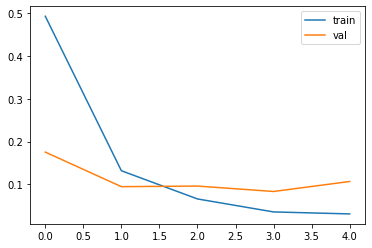

In [33]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# question-answering pipeline

In [34]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

# test

In [35]:
def test_model(df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the Applicant?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        #predict = QA_input['context'][res['start']:res['end']]
        predict = QA_input['context'][0:res['end']]
        row = pd.DataFrame({
            'label':sample['Y_label'].values[0],
            'predict:':predict},index=[i])
        if sample['Y_label'].values[0] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [36]:
all_res = test_model(val_df.sample(99))
all_res

  0%|          | 0/99 [00:00<?, ?it/s]

,label,predict:,是否全對
1829,BHILOSA INDUSTRIES PVT LTD,BHILOSA INDUSTRIES PVT,No
1426,CHUNG WAI CHEMICAL LIMITED,CHUNG WAI CHEMICAL LIMITED,Yes
175,PUYOUNG IND CO LTD,PUYOUNG IND CO LTD,Yes
2291,SODINOR,SODINOR 456 AVENUE DU MAL DE TASSIGNY,No
1506,XIAMEN HOREN IMPORT AND EXPORT,XIAMEN HOREN IMPORT AND EXPORT,Yes
...,...,...,...
1867,U KWONG INDUSTRIAL CO LTD,U KWONG INDUSTRIAL CO LTD,Yes
188,WINSON OIL TRADING PTE LTD,WINSON OIL TRADING PTE LTD,Yes
2290,HELISTROM SDNBHD,HELISTROM SDNBHD,Yes
2031,BRENNTAG CANADA INC,BRENNTAG CANADA INC,Yes


In [39]:
all_res['predict:']

1829                   BHILOSA INDUSTRIES PVT
1426               CHUNG WAI CHEMICAL LIMITED
175                        PUYOUNG IND CO LTD
2291    SODINOR 456 AVENUE DU MAL DE TASSIGNY
1506           XIAMEN HOREN IMPORT AND EXPORT
                        ...                  
1867                U KWONG INDUSTRIAL CO LTD
188                WINSON OIL TRADING PTE LTD
2290                         HELISTROM SDNBHD
2031                      BRENNTAG CANADA INC
932             ZHEJIANG FUTURE PETROCHEMICAL
Name: predict:, Length: 99, dtype: object

# claculate acc and jaccard

In [40]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


def get_acc(df):
    df['predict'] = [[i] for i in df['predict:']]
    correct = []
    correct_label = []
    for i in df.index:
        jacs = []
        for j in df.loc[i,'predict']:
            jacs.append(get_jaccard_sim(df.loc[i,'label'],j))
        if max(jacs) >= 0.75:
            correct.append('yes')
        else:
            correct.append('no')
    return pd.Series(correct).value_counts()['yes']/len(correct)

acc = get_acc(all_res)
print('acc:',acc)
jaccard_avg_score = np.mean([ get_jaccard_sim(all_res.label.loc[i],all_res['predict:'].loc[i]) for i in all_res.index])
print('jaccard_avg_score:',jaccard_avg_score)

acc: 0.8686868686868687
jaccard_avg_score: 0.9140692640692639


# save model

In [41]:
torch.save(model.state_dict(),'Product_Data_SQuAD_model_開狀人.pt')